In [ ]:
!pip install pydotplus
!pip install six

In [58]:
!pip install mglearn

     |████████████████████████████████| 542kB 5.3MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=ebc40c3911df5688f8d477e4ab1d7dc17369e752fb35c35c81f763f4abc777db
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn


In [4]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image, HTML
from tqdm import tqdm

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from six import StringIO
from sklearn.neural_network import MLPRegressor

# For scoring

# For validation
from sklearn.model_selection import train_test_split as split


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
# the dataset can be found at https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=tracks.csv

# Pre-Processing
First, we import a clean version of the data, without id, name, year and release_date and remove the duplicates.

In [6]:
# Read column names from file
cols = list(pd.read_csv('/content/drive/MyDrive/BDA EXAM/data_o.csv', nrows =1))
df = pd.read_csv('/content/drive/MyDrive/BDA EXAM/data_o.csv', usecols=[i for i in cols if i not in ['id','name','release_date', 'year']])



# Remove duplicated
df = df[~df.duplicated()==1]
# df = df.sample(frac=0.3)
#Split the data to train and test
X_train, X_test, y_train, y_test = split(df.drop('popularity', axis=1), df['popularity'])

<p>After exploring the data, some features need pre-processing. This will be done in the following order:</p>
<ol>
<li><p>Unique feature transformers</p>
</li>
<li><p>OneHotEncoder (aka dummies) for relevant features</p>
</li>
<li><p>MinMaxScaling for relevant features</p>
</li>
<li><p>Target scaling</p>
</li>
</ol>

<strong>AritistsTransformer</strong>
<p>Here we need to replace object data of the artists with some numerical indicator that identify the artist.</p>

In [7]:
class ArtistsTransformer():
    """ This transformer recives a DF with a feature 'artists' of dtype object
      and convert the feature to a float value as follows:
      1. Replace the data with the artists mean popularity
      2. Replace values where artists appear less than MinCnt with y.mean()
      3. Replace values where artists appear more than MaxCnt with 0
      
      PARAMETERS:
      ----------
      MinCnt (int): Minimal treshold of artisits apear in dataset, default = 3
      MaxCnt (int): Maximal treshold of artisits apear in dataset, default = 600

      RERTURN:
      ----------
      A DataFrame with converted artists str feature to ordinal floats
  """
    
    def __init__(self, MinCnt = 3.0, MaxCnt = 600.0):
        self.MinCnt = MinCnt
        self.MaxCnt = MaxCnt
        self.artists_df = None
    def fit (self, X, y):
        self.artists_df =  y.groupby(X.artists).agg(['mean', 'count'])
        self.artists_df.loc['unknown'] = [y.mean(), 1]
        self.artists_df.loc[self.artists_df['count'] <= self.MinCnt, 'mean'] = y.mean()
        self.artists_df.loc[self.artists_df['count'] >= self.MaxCnt, 'mean'] = 0
        return self
    def transform(self, X, y=None):
        X['artists'] = np.where(X['artists'].isin(self.artists_df.index), X['artists'], 'unknown')
        X['artists'] = X['artists'].map(self.artists_df['mean'])
        return X

In [8]:
# Apply AritistsTransformer on train and test seperatly
artists_transformer = ArtistsTransformer(MinCnt=2)
X_train = artists_transformer.fit(X_train, y_train).transform(X_train, y_train)
X_test = artists_transformer.transform(X_test, y_test)

<strong>Instrumentalness Transformer</strong>

In [9]:
def instrumentalness_criteria(X):
    X['instrumentalness'] = list(map((lambda x: 1 if x < 0.1 else (3 if x > 0.95 else 2)), X.instrumentalness))

instrumentalness_tranformer = FunctionTransformer(instrumentalness_criteria)
instrumentalness_tranformer.transform(X_train)
instrumentalness_tranformer.transform(X_test)

<strong>Tempo Transformer</strong>

In [10]:
class ReplaceZeroTransformer():
    """Eliminates Zero values from tempo columns and replace it 
       with the median or mean of non-zero values as specified.
       defaut is set to 'median'.
    """

    def __init__(self, method='median'):
        self.method = method

    def transform(self, X):
        if self.method == 'median':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].median()
        elif self.method == 'mean':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].mean()
        else:
            raise Exception("Method can be 'median' or 'mean' only!")
        return X

In [11]:
tempo_transformer = ReplaceZeroTransformer()
X_train = tempo_transformer.transform(X_train)
X_test = tempo_transformer.transform(X_test)

<strong>OneHotEncoder</strong>
<p>We use OneHotEncoder from SKlearn to create dummies</p>

In [12]:
ohe = OneHotEncoder(categories='auto', drop='first')

# Train
feature_arr = ohe.fit_transform(X_train[['instrumentalness','key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(X_train['key'].values))[1:]]
instrumentalness_key = ['ins_'+str(i) for i in list(set(X_train['instrumentalness'].values))[1:]]
feature_labels = columns_key + instrumentalness_key
feature_labels = np.concatenate((feature_labels), axis=None)
features = pd.DataFrame(feature_arr, columns = feature_labels, index = X_train.index)
X_train = pd.concat([X_train, features], axis=1).drop(['key','instrumentalness'], axis=1)

# Test
feature_arr = ohe.fit_transform(X_test[['instrumentalness','key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(X_test['key'].values))[1:]]
instrumentalness_key = ['ins_'+str(i) for i in list(set(X_test['instrumentalness'].values))[1:]]
feature_labels = columns_key + instrumentalness_key
feature_labels = np.concatenate((feature_labels), axis=None)
features = pd.DataFrame(feature_arr, columns = feature_labels, index = X_test.index)
X_test = pd.concat([X_test, features], axis=1).drop(['key','instrumentalness'], axis=1)

<strong>MinMaxScaler Encoder</strong>

In [13]:
scaler = MinMaxScaler()
cols = ['duration_ms','loudness','tempo']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.fit_transform(X_test[cols])

<strong>Target scaling</strong>

In [14]:
# Divide the popularity by 100
y_train = y_train / 100
y_test = y_test / 100

<strong>Verification</strong>

In [15]:
nl = '\n'
print(f'X_train shape is: {X_train.shape} {nl}y_train shape is: {y_train.shape} {nl}X_test shape is: {X_test.shape} {nl}y_test shape is: {y_test.shape}')

X_train shape is: (127325, 25) 
y_train shape is: (127325,) 
X_test shape is: (42442, 25) 
y_test shape is: (42442,)


In [16]:
X_train.head(3)

,valence,acousticness,artists,danceability,duration_ms,energy,explicit,liveness,loudness,mode,speechiness,tempo,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,ins_2,ins_3
110222,0.168,0.715,0.000000,0.350,0.03287,0.449,0,0.1690,0.832261,1,0.0273,0.615047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
141764,0.838,0.868,0.086957,0.522,0.03311,0.257,0,0.0966,0.761961,0,0.0585,0.457088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
88139,0.415,0.857,55.347826,0.610,0.03541,0.265,0,0.1110,0.740177,1,0.0339,0.270591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
X_train.describe().drop(['count','25%', '50%', '75%'])

,valence,acousticness,artists,danceability,duration_ms,energy,explicit,liveness,loudness,mode,speechiness,tempo,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,ins_2,ins_3
mean,0.528561,0.499970,30.825957,0.537460,0.041848,0.483516,0.085372,0.205816,0.760490,0.707465,0.098724,0.404669,0.239293,0.009747,0.075484,0.110387,0.042655,0.076097,0.096030,0.051098,0.121618,0.06302,0.103632,0.071078,0.062737
std,0.262898,0.375601,16.978416,0.176244,0.023437,0.267637,0.279436,0.174558,0.088796,0.454928,0.163342,0.143638,0.426654,0.098244,0.264172,0.313373,0.202078,0.265154,0.294633,0.220198,0.326845,0.24300,0.304784,0.256956,0.242490
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,0.996000,87.666667,0.986000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [18]:
y_train.describe().drop(['count','25%', '50%', '75%'])

mean    0.316024
std     0.217672
min     0.000000
max     1.000000
Name: popularity, dtype: float64

# Models

# Linear Regression

In [200]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression


In [201]:
#DEFAULT

regressor_lin = LinearRegression()
regressor_lin.fit(X_train,y_train)

y_pred_lin = regressor_lin.predict(X_test)

In [202]:
print("Accuracy on training set: {:.3f}".format(regressor_lin.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(regressor_lin.score(X_test, y_test)))

Accuracy on training set: 0.664
Accuracy on test set: 0.629


In [ ]:
print("lr.coef_: {}".format(regressor_lin.coef_))
print("lr.intercept_: {}".format(regressor_lin.intercept_))

lr.coef_: [-0.08504801 -0.08851167  0.00775322  0.13211386  0.05032785  0.02967988
  0.06604972 -0.05072202  0.07102222 -0.00477359 -0.12494695  0.02809359
 -0.0274029   0.01514668  0.00814109 -0.00366623 -0.00459536  0.00387353
  0.00233066  0.00828804  0.00028379  0.00775126 -0.00096983  0.00153805
 -0.00185688]
lr.intercept_: 0.038774215354108965


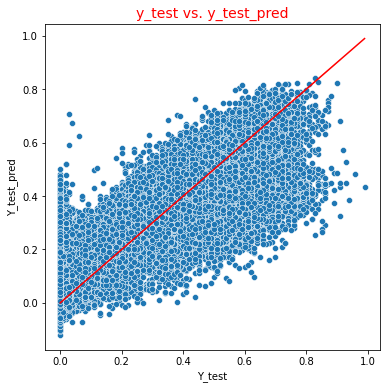

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred_lin)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

# KNeighborsRegressor

### Default parameters

In [19]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()

In [101]:
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [102]:
print('KNeighborsRegressor with default parameters')
print('Estimated accuracy on the training set: {:.3f}'.format(knn.score(X_train, y_train)))
print('Estimated accuracy on the test set: {:.3f}'.format(knn.score(X_test, y_test)))



KNeighborsClassifier with default parameters
Estimated accuracy on the training set: 0.801
Estimated accuracy on the test set: 0.667


### Improved model

In [27]:
best_test_score = 0
best_train_score = 0

training_accuracy1 = []
test_accuracy1 = []
res1 = []

training_accuracy2 = []
test_accuracy2 = []
res2 = []

# try n_neighbors from 1 to 10
neighbors_settings = [1,5,10,20,25,50,100,150]

for n_neighbors in neighbors_settings:
  # build the model
  knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights='uniform')
  knn.fit(X_train, y_train)

  trainRes1 = knn.score(X_train,y_train)
  testRes1 = knn.score(X_test,y_test)
  res1.append((testRes1,trainRes1,n_neighbors))
   # record training set accuracy
  training_accuracy1.append(trainRes1)
  # record generalization accuracy
  test_accuracy1.append(testRes1)
  print (n_neighbors, "uniform")

  # if we got a better score, store the score and parameters
  if testRes1 > best_test_score:
    best_test_score = testRes1
    best_train_score = trainRes1
    best_parameters = {'n_neighbors': n_neighbors, 'weights': 'uniform'}


for n_neighbors in neighbors_settings:
  # build the model
  knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights = 'distance')
  knn.fit(X_train, y_train)

  trainRes2 = knn.score(X_train,y_train)
  testRes2 = knn.score(X_test,y_test)
  res2.append((testRes2,trainRes2,n_neighbors))
 # record training set accuracy
  training_accuracy2.append(trainRes2)
  # record generalization accuracy
  test_accuracy2.append(testRes2)
  (n_neighbors, "distance")
  
  # if we got a better score, store the score and parameters
  if testRes2 > best_test_score:
   best_test_score = testRes2
   best_train_score = trainRes2
   best_parameters = {'n_neighbors': n_neighbors, 'weights': 'distance'}



print("Best score: {:.2f}".format(best_test_score))
print("Best parameters: {}".format(best_parameters))


Best score: 0.70
Best parameters: {'n_neighbors': 25, 'weights': 'distance'}


In [39]:
print("Best parameters: {}".format(best_parameters))
print("Best train score: {:.3f}".format(best_train_score))
print("Best score: {:.3f}".format(best_test_score))


Best parameters: {'n_neighbors': 25, 'weights': 'distance'}
Best train score: 0.997
Best test score: 0.703


In [ ]:
print("Best score: {:.2f}".format(best_test_score))
print("Best parameters: {}".format(best_parameters))

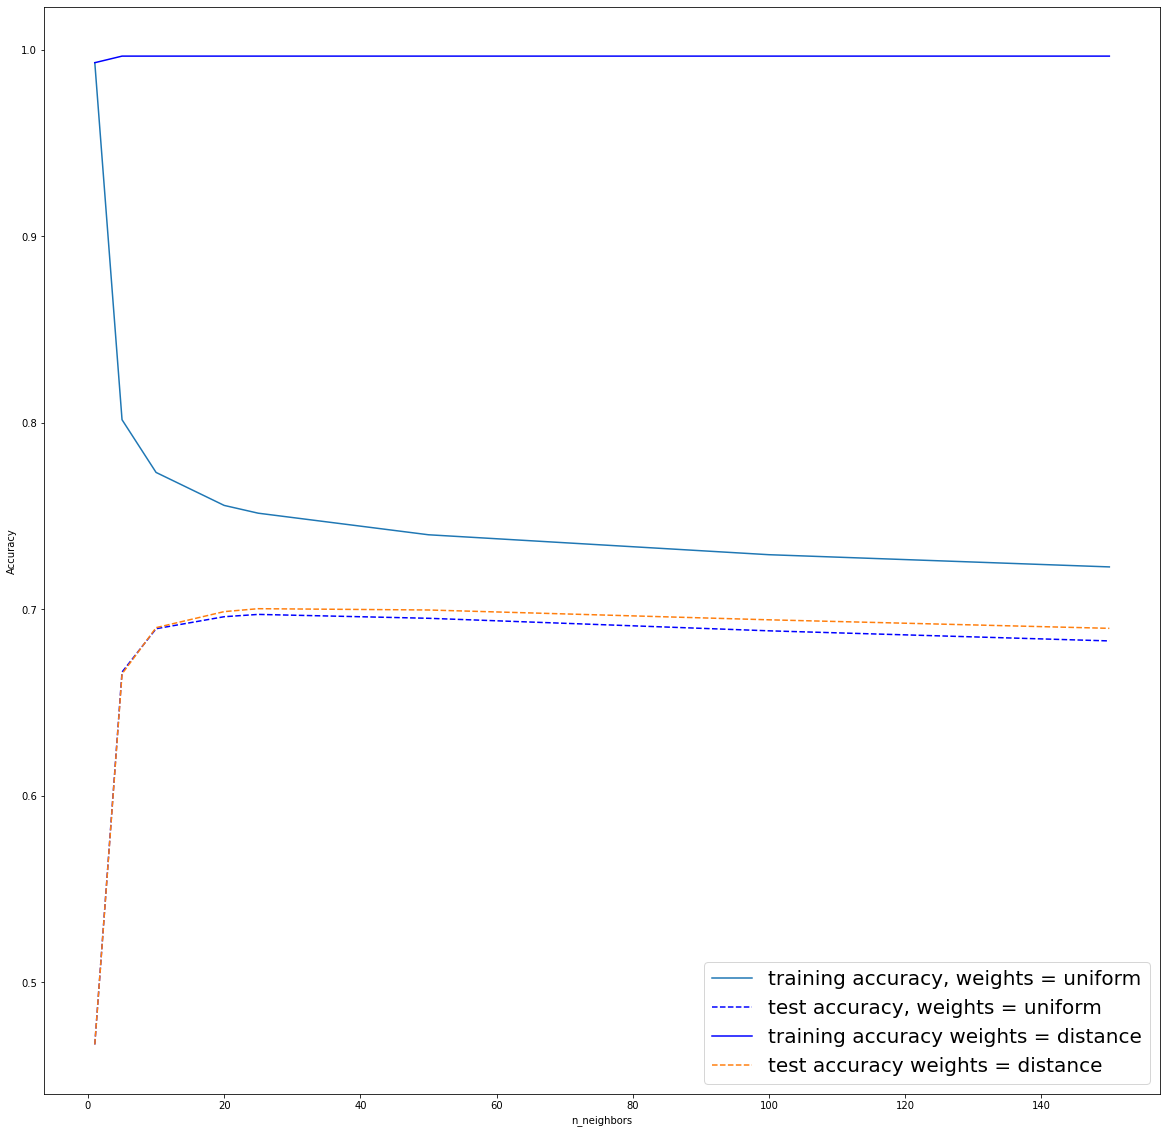

In [28]:
plt.figure(figsize=(20, 20))
plt.plot(neighbors_settings, training_accuracy1, label="training accuracy, weights = uniform")
plt.plot(neighbors_settings, test_accuracy1, label="test accuracy, weights = uniform", color="blue", ls='--')
plt.plot(neighbors_settings, training_accuracy2, label="training accuracy weights = distance", color="blue")
plt.plot(neighbors_settings, test_accuracy2, label="test accuracy weights = distance", ls='--')
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend(fontsize=20)

# Decision Tree Regression

### Default

In [35]:
regressor_dt= DecisionTreeRegressor()

In [36]:
regressor_dt.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [37]:
print("Accuracy on training set: {:.3f}".format(regressor_dt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(regressor_dt.score(X_test, y_test)))

Accuracy on training set: 0.996
Accuracy on test set: 0.443


Accuracy on test set: 0.651


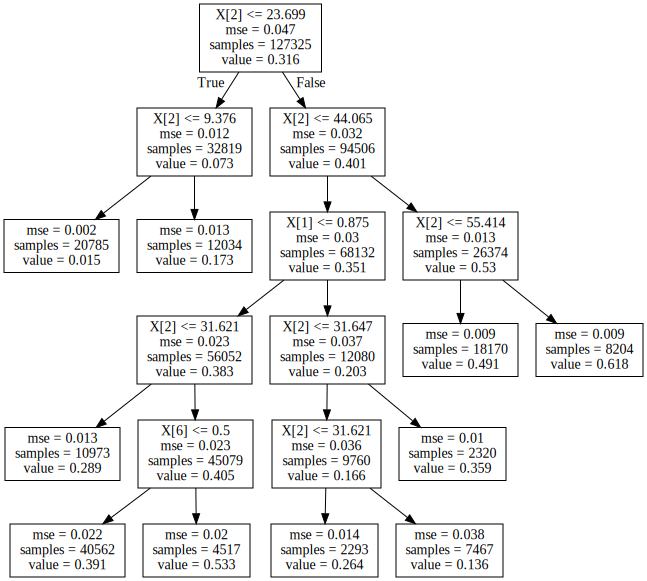

In [151]:
import graphviz

tree = DecisionTreeRegressor(random_state=0, max_depth=5, max_leaf_nodes=10)
tree.fit(X_train,y_train)
export_graphviz(tree, out_file="tree.dot", class_names=["malignant","benign"])

print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

with open("tree.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

### Improved model

In [240]:
best_score = 0

for f in range (2,200):
    regressor_dt2= DecisionTreeRegressor(max_leaf_nodes = f)
    regressor_dt2.fit(X_train,y_train)
    y_pred_dt= regressor_dt2.predict(X_test)
    trainRes = regressor_dt2.score(X_train,y_train)
    testRes = regressor_dt2.score(X_test,y_test)
    if testRes > best_score:
      best_score = testRes
      best_parameters = {'max_leaf_nodes': f, 'max_depth': depth}
print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))
        

KeyboardInterrupt: ignored

In [239]:
tree = DecisionTreeRegressor(max_leaf_nodes=155)
tree.fit(X_train,y_train)

print("Training set score: {:.5f}".format(tree.score(X_train, y_train)))
print("Test set score: {:.5f}".format(tree.score(X_test, y_test)))


Training set score: 0.75833
Test set score: 0.71348


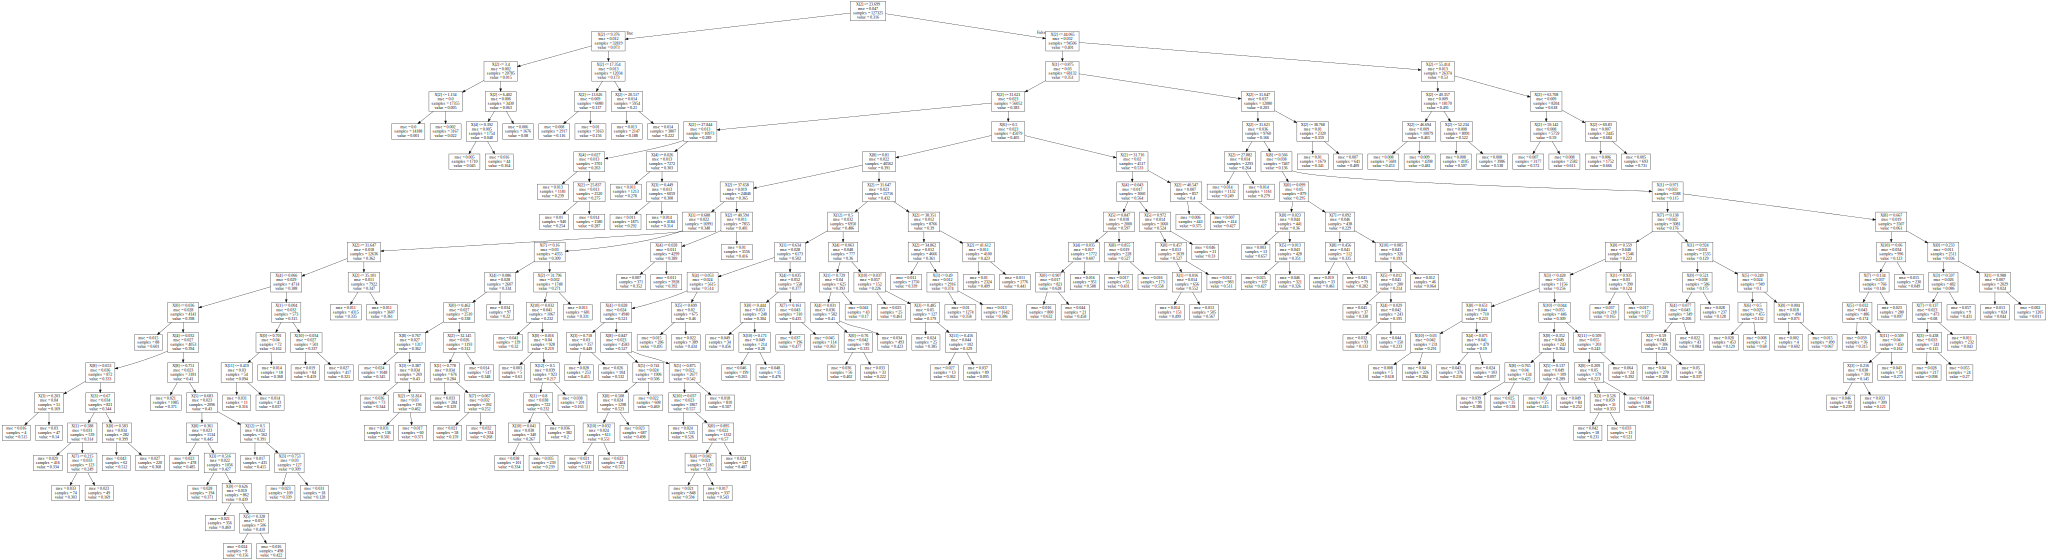

In [141]:
tree = DecisionTreeRegressor(random_state=10, max_leaf_nodes=155)
tree.fit(X_train,y_train)
export_graphviz(tree, out_file="tree.dot", class_names=["malignant","benign"])

with open("tree.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

In [40]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500).fit(X_train, y_train)
print("Score without interactions: {:.3f}".format(
    rf.score(X_test, y_test)))
#rf = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
#print("Score with interactions: {:.3f}".format(rf.score(X_test_poly, y_test)))

KeyboardInterrupt: ignored

In [ ]:
print("train score: {:.3f}".format(
    rf.score(X_train, y_train)))
print("test score: {:.3f}".format(
    rf.score(X_test, y_test)))

In [ ]:
res = []
#for n in range (,11):
for s in range (1,11):
    rf2 = RandomForestRegressor(n_estimators=100, random_state=s)
    rf2.fit(X_train,y_train)
    y_pred_rf = rf2.predict(X_test)
    trainRes = rf2.score(X_train,y_train)
    testRes = rf2.score(X_test,y_test)
    res.append((testRes,trainRes,s))
    print (s, n)
        

for r in sorted(res,key=lambda e:e[0], reverse=True):   
    print("{} random_state  Train: {}  Test: {}   ".format(r[2],r[1],r[0]))

# Neural network

### Default

In [260]:
mlp = MLPRegressor(random_state=0).fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test, y_test)))

Accuracy on training set: 0.716
Accuracy on test set: 0.687


### Rescaled

In [262]:
mean_on_train = X_train.mean(axis=0)
# compute the standard deviation of each feature on the training set
std_on_train = X_train.std(axis=0)

# subtract the mean, and scale by inverse standard deviation
# afterward, mean=0 and std=1
X_train_scaled = (X_train - mean_on_train) / std_on_train
# use THE SAME transformation (using training mean and std) on the test set
X_test_scaled = (X_test - mean_on_train) / std_on_train

mlp = MLPRegressor(random_state=0)
mlp.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 0.733
Accuracy on test set: 0.701


### Increased iterations

In [269]:
mlp = MLPRegressor(random_state=0, solver='lbfgs', max_iter=100000)
mlp.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

Accuracy on training set: 0.762
Accuracy on test set: 0.723


# Ridge regression

In [180]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.5f}".format(ridge.score(X_test, y_test)))

Training set score: 0.66357
Test set score: 0.62890


In [181]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge10.score(X_train, y_train)))
print("Test set score: {:.5f}".format(ridge10.score(X_test, y_test)))

Training set score: 0.66357
Test set score: 0.62890


In [190]:
ridge01 = Ridge(alpha=0.000000000001).fit(X_train, y_train)
print("Training set score: {:.5f}".format(ridge01.score(X_train, y_train)))
print("Test set score: {:.5f}".format(ridge01.score(X_test, y_test)))

Training set score: 0.66357
Test set score: 0.62890


# Lasso

In [185]:
from sklearn.linear_model import Lasso
lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.54
Test set score: 0.49
Number of features used: 1


In [188]:
# we increase the default setting of "max_iter",
# otherwise the model would warn us that we should increase max_iter.
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso001.coef_ != 0)))

Training set score: 0.62
Test set score: 0.57
Number of features used: 2


In [199]:
lasso00001 = Lasso(alpha=0.0005, max_iter=100000).fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso00001.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso00001.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso00001.coef_ != 0)))

Training set score: 0.66
Test set score: 0.62
Number of features used: 12


Text(0, 0.5, 'Coefficient magnitude')

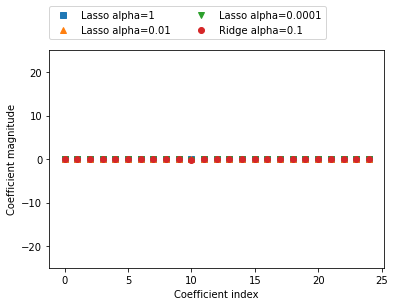

In [ ]:
plt.plot(lasso.coef_, 's', label="Lasso alpha=1")
plt.plot(lasso001.coef_, '^', label="Lasso alpha=0.01")
plt.plot(lasso00001.coef_, 'v', label="Lasso alpha=0.0001")
plt.plot(ridge01.coef_, 'o', label="Ridge alpha=0.1")
plt.legend(ncol=2, loc=(0, 1.05))
plt.ylim(-25, 25)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")